# Overview
This notebook test the perfomances of OCT2Hist model end to end on a reference dataset described oin [our paper](https://www.medrxiv.org/content/10.1101/2021.03.31.21254733v1).

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-UseModel/blob/main/test_run_oct2hist_end2end.ipynb) and run.

## Notebook's Inputs:

In [1]:
# Pre-processed dataset
preprocessed_dataset_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/"

# Define input images
preprocessed_oct_image_paths = [
 (preprocessed_dataset_path + "LE-03-Slide04_Section01_yp0_patch01_real_A.png"), # Used in Paper Figure 3.b
 (preprocessed_dataset_path + "LG-19-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.c
 (preprocessed_dataset_path + "LF-01-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.d
 (preprocessed_dataset_path + "LG-44-Slide05_Section03_yp0_patch01_real_A.png"), # Used in Paper Figure 3.e
]

# Raw images dataset
raw_dataset_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Raw Data Used In Paper (Paper V2)/"

# Define input images
raw_dataset_path_oct_image_paths = [
 (raw_dataset_path + "LE-03 - Slide04_Section01 (Fig 3.b)/OCTAligned.tiff"), # Used in Paper Figure 3.b
 (raw_dataset_path + "LG-19 - Slide04_Section02 (Fig 3.c)/OCTAligned.tiff"), # Used in Paper Figure 3.c
 (raw_dataset_path + "LF-01 - Slide04_Section02 (Fig 3.d)/OCTAligned.tiff"), # Used in Paper Figure 3.d
 (raw_dataset_path + "LG-44 - Slide05_Section03 (Fig 3.e)/OCTAligned.tiff"), # Used in Paper Figure 3.e
]

## Set Up Environment

In [2]:
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference
%cd OCT2Hist-ModelInference

import cv2
import matplotlib.pyplot as plt
import numpy as np
import oct2hist
from google.colab import drive
from utils.crop import crop
drive.mount('/content/drive/')

Cloning into 'OCT2Hist-ModelInference'...
remote: Enumerating objects: 617, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 617 (delta 63), reused 1 (delta 0), pack-reused 504
Receiving objects: 100% (617/617), 20.36 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (320/320), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
/content/OCT2Hist-ModelInference
Mounted at /content/drive/


In [3]:
# Inputs are path to the oct image (we can extract the file paths from the oct), and virtual histology images
def display_images(
    raw_dataset_path_oct_image_paths, model_o2h_inputs,
    model_virtual_histology_images, preprocessed_oct_image_paths):
  fig = plt.figure(figsize=(13, 10))

  n = len(raw_dataset_path_oct_image_paths)
  for i in range(len(preprocessed_oct_image_paths)):
    raw_dataset_path_oct_image_path = raw_dataset_path_oct_image_paths[i]
    preprocessed_oct_image_path = preprocessed_oct_image_paths[i]

    im = cv2.imread(raw_dataset_path_oct_image_path)
    fig.add_subplot(n, 5, i*5+1)
    plt.imshow(im)
    plt.axis('off')
    if i==0:
      plt.title('Raw OCT Image')

    fig.add_subplot(n, 5, i*5+2)
    plt.imshow(model_o2h_inputs[i])
    plt.axis('off')
    if i==0:
      plt.title('Model Input\n(Current Model)')

    im = cv2.imread(preprocessed_oct_image_path)
    fig.add_subplot(n, 5, i*5+3)
    plt.imshow(im)
    plt.axis('off')
    if i==0:
      plt.title('Model Input\n(Paper Reference)')

    fig.add_subplot(n, 5, i*5+4)
    plt.imshow(cv2.resize(model_virtual_histology_images[i], [256,256] , interpolation=cv2.INTER_AREA))
    plt.axis('off')
    if i==0:
      plt.title('Model Output\n(Current Model)')

    im = cv2.imread(preprocessed_oct_image_path.replace("_real_A", "_fake_B"))
    im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    fig.add_subplot(n, 5, i*5+5)
    plt.imshow(im2)
    plt.axis('off')
    if i==0:
      plt.title('Model Output\n(Paper Reference)')
plt.show()

## Loop over all images and compare

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


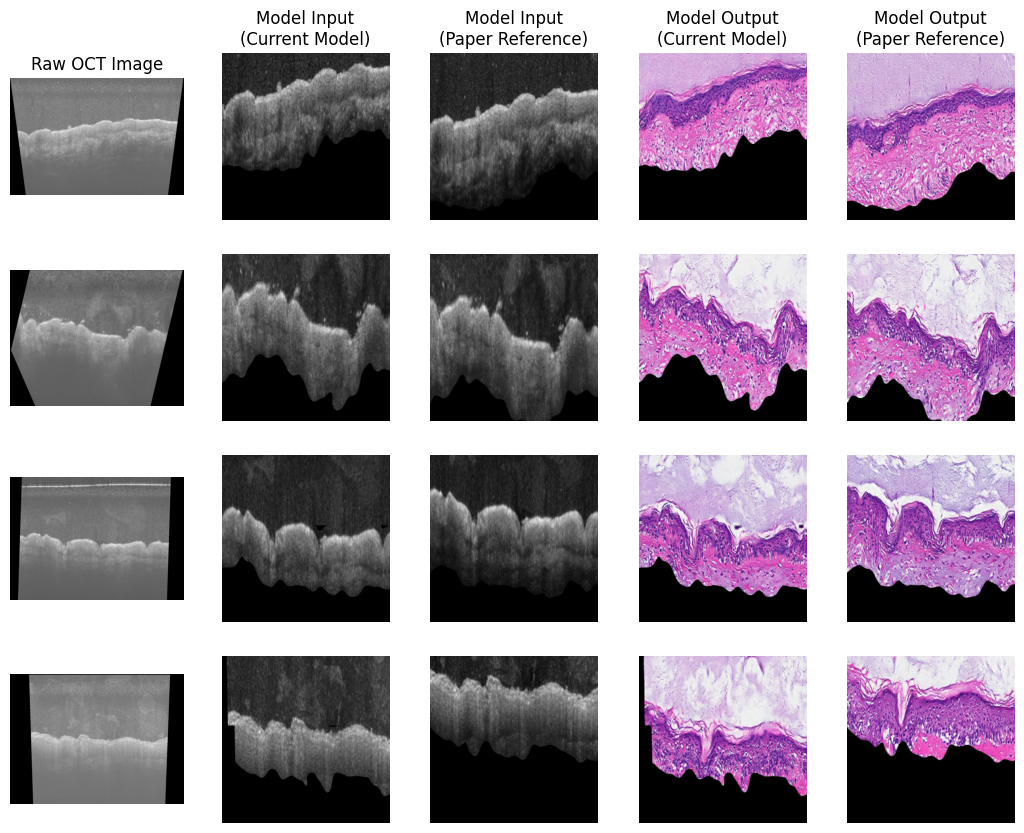

In [4]:
# Set up the environment
oct2hist.setup_network()

# Create container for output images
model_virtual_histology_images = []
model_o2h_inputs = []

for raw_dataset_path_oct_image_path in raw_dataset_path_oct_image_paths:

  # Load image
  input_oct_image = cv2.imread(raw_dataset_path_oct_image_path)

  # Crop using a default "in the middle" cropper
  cropped = crop(input_oct_image,
                 target_width=1024, target_height=512, x0=135, z0=300)

  # Run Inference
  model_virtual_histology_image, _, o2h_input = oct2hist.run_network(cropped)
  model_virtual_histology_images.append(model_virtual_histology_image)
  model_o2h_inputs.append(o2h_input)

# Present results
display_images(raw_dataset_path_oct_image_paths, model_o2h_inputs,
    model_virtual_histology_images, preprocessed_oct_image_paths)